In [1]:
import math, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time

torch.backends.cudnn.benchmark = True
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
BATCH = 128

tfm = transforms.Compose([
    transforms.ToTensor(),                    # [0,1]
    transforms.Lambda(lambda x: x*2.0 - 1.0)  # [-1,1]
])

train_ds = datasets.MNIST(root='./data', train=True,  download=True, transform=tfm)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


In [3]:
class PCN(nn.Module):
    """
    Top-down generative weights W_l: predict z_l from z_{l+1}:  ẑ_l = phi(W_l z_{l+1})
    Levels: l = 0 .. L-1;  level 0 is pixels (28*28), level L is labels (10).
    Energy: sum_l ||e_l||^2 with e_0 = x - ẑ_0, e_l = z_l - ẑ_l (1..L-1), e_L = z_L - y.
    Inference: local gradient steps on z_l to reduce energy; learning: local delta‑rule on W_l.
    """
    def __init__(self, dims, act_name='tanh'):
        super().__init__()
        self.dims = dims  # e.g. [784, 512, 256, 64, 10]  (0..L)
        self.L = len(dims) - 1
        self.W = nn.ParameterList()
        for l in range(self.L):
            # W_l maps z_{l+1} -> z_l  (shape: [dim_l, dim_{l+1}])
            w = torch.randn(dims[l], dims[l+1]) * (1.0 / math.sqrt(dims[l+1]))
            self.W.append(nn.Parameter(w))
        # Simple linear probe operating on last latent before labels
        self.readout = nn.Linear(self.dims[self.L-1], self.dims[self.L])
        nn.init.xavier_uniform_(self.readout.weight)
        nn.init.zeros_(self.readout.bias)
        if act_name == 'tanh':
            self.phi  = torch.tanh
            self.dphi = lambda u: 1.0 - torch.tanh(u)**2
        else:
            raise ValueError('Use tanh here for stable PCN.')

    @torch.no_grad()
    def init_latents(self, B):
        # z_0 is clamped to image x externally; we maintain z_1..z_{L-1} and z_L.
        zs = [None] * (self.L + 1)
        for l in range(1, self.L):
            zs[l] = torch.zeros(B, self.dims[l], device=device)
        zs[self.L] = torch.zeros(B, self.dims[self.L], device=device)  # top (labels)
        return zs

    def predict_down(self, zs):
        """
        Given current zs[1..L], compute preactivations and predictions for all lower levels.
        pre[l] = W_l @ z_{l+1}; hat[l] = phi(pre[l]); for l = 0..L-1.
        """
        pre, hat = [None]*self.L, [None]*self.L
        for l in range(self.L):
            pre[l] = zs[l+1] @ self.W[l].T                   # [B, dim_l]
            hat[l] = self.phi(pre[l])
        return pre, hat

    @torch.no_grad()
    def inference(self, x, y=None, T=20, eta_z=0.1, zs=None, log_errors=False):
        """
        x: [B, 784] in [-1,1]. y: one-hot [B,10] or None.
        Returns zs after T inference steps. Optionally logs per-step mean|error|.
        """
        B = x.size(0)
        if zs is None:
            zs = self.init_latents(B)

        # Optional logs
        logs = defaultdict(list) if log_errors else None

        for _ in range(T):
            pre, hat = self.predict_down(zs)

            # Errors
            e = [None]*(self.L+1)
            e[0] = x - hat[0]                         # pixel error
            for l in range(1, self.L):
                e[l] = zs[l] - hat[l]
            if y is None:
                e[self.L] = zs[self.L]                # prior = 0 at top for recognition
            else:
                e[self.L] = zs[self.L] - y            # supervised clamp at top

            # Log mean abs error
            if log_errors:
                for l in range(self.L+1):
                    logs[f'e{l}'].append(e[l].abs().mean().item())

            # Latent updates (z_0 fixed)
            # For l = 1..L-1:  dz_l = -e_l + (e_{l-1} * dphi(pre_{l-1})) @ W_{l-1}
            for l in range(1, self.L):
                fb = (e[l-1] * self.dphi(pre[l-1])) @ self.W[l-1]   # [B, dim_l]
                dz = -e[l] + fb
                zs[l] += eta_z * dz

            # Top level
            fb_top = (e[self.L-1] * self.dphi(pre[self.L-1])) @ self.W[self.L-1]
            dzL = -e[self.L] + fb_top
            zs[self.L] += eta_z * dzL

        return zs, logs

    @torch.no_grad()
    def learn(self, x, zs, eta_w=1e-3):
        """
        Local delta‑rule on W_l:  dW_l ∝ (e_l * dphi(pre_l))^T @ z_{l+1}
        Uses current zs and x as clamped bottom.
        """
        pre, hat = self.predict_down(zs)
        e = [None]*(self.L+1)
        e[0] = x - hat[0]
        for l in range(1, self.L):
            e[l] = zs[l] - hat[l]
        # (Top e_L is for labels and does not update W directly.)

        B = x.size(0)
        for l in range(self.L):
            g = (e[l] * self.dphi(pre[l])).T @ zs[l+1]   # [dim_l, dim_{l+1}]
            g /= B
            self.W[l].add_(eta_w * g)

    @torch.no_grad()
    def reconstruct(self, zs):
        pre, hat = self.predict_down(zs)
        return hat[0]  # pixel prediction in [-1,1]

    def classify(self, zs):
        # Linear probe on penultimate latent for recognition
        return self.readout(zs[self.L-1])

# Train and eval

In [4]:
# Architecture: pixels -> 512 -> 256 -> 64 -> 10(top)
dims = [28*28, 512, 256, 64, 10]
model = PCN(dims).to(device)
clf_opt = torch.optim.Adam(model.readout.parameters(), lr=1e-3)
clf_criterion = nn.CrossEntropyLoss()

# PCN params
T_infer   = 20         # latent inference steps per batch
ETA_Z     = 0.15       # latent step size
ETA_W     = 2e-3       # weight learning rate
EPOCHS    = 5
PRINT_EVERY = 100


In [5]:
def one_hot(y, n=10):
    return F.one_hot(y, num_classes=n).float()

history = {'train_loss': [], 'train_acc_probe': [], 'clf_loss': [], 'clf_acc': []}
start = time()

for ep in range(1, EPOCHS+1):
    model.train()
    running_e0 = 0.0
    running_clf = 0.0
    epoch_e0_sum = 0.0
    seen = 0
    epoch_clf_loss = 0.0
    clf_correct = 0
    clf_seen = 0
    for it, (x, y) in enumerate(train_loader, 1):
        x = x.to(device).view(x.size(0), -1)     # [B,784], [-1,1]
        targets = y.to(device)
        yh = one_hot(targets, 10)                # [B,10]

        # Inference with supervised clamp at top for generative learning
        zs_sup, _ = model.inference(x, y=yh, T=T_infer, eta_z=ETA_Z, zs=None, log_errors=False)

        # Learn local weights
        model.learn(x, zs_sup, eta_w=ETA_W)

        # Track mean |pixel error| after inference
        with torch.no_grad():
            pre, hat = model.predict_down(zs_sup)
            e0 = (x - hat[0]).abs().mean().item()
            running_e0 += e0
            epoch_e0_sum += e0
            seen += 1

        # Recognition run without label clamp feeding linear probe
        zs_rec, _ = model.inference(x, y=None, T=T_infer, eta_z=ETA_Z, zs=None, log_errors=False)
        logits = model.classify(zs_rec)
        loss_clf = clf_criterion(logits, targets)
        clf_opt.zero_grad(set_to_none=True)
        loss_clf.backward()
        clf_opt.step()
        running_clf += loss_clf.item()
        epoch_clf_loss += loss_clf.item() * targets.size(0)
        clf_correct += (logits.argmax(dim=1) == targets).sum().item()
        clf_seen += targets.size(0)

        if it % PRINT_EVERY == 0:
            mean_e0 = running_e0 / max(1, seen)
            mean_clf = running_clf / max(1, seen)
            print(f'Epoch {ep} | iter {it}: mean|e0|={mean_e0:.4f} | clf_loss={mean_clf:.4f}')
            running_e0, running_clf, seen = 0.0, 0.0, 0

    num_batches = max(1, it)
    history['train_loss'].append(epoch_e0_sum / num_batches)
    history['clf_loss'].append(epoch_clf_loss / max(1, clf_seen))
    history['clf_acc'].append(clf_correct / max(1, clf_seen))

    # quick probe: recognition without label clamp → classify via top latent
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device).view(x.size(0), -1)
            zs, _ = model.inference(x, y=None, T=T_infer, eta_z=ETA_Z, zs=None, log_errors=False)
            logits = model.classify(zs)
            pred = logits.argmax(dim=1).cpu()
            correct += (pred == y).sum().item()
            total += y.size(0)
            if total >= 10000:   # limit eval time
                break
    acc = correct / total
    history['train_acc_probe'].append(acc)
    print(f'Probe train acc (subset): {acc:.3f}')

print(f'Training time: {time()-start:.1f}s')


Epoch 1 | iter 100: mean|e0|=0.2530 | clf_loss=2.2198
Epoch 1 | iter 200: mean|e0|=0.1837 | clf_loss=1.9683
Epoch 1 | iter 200: mean|e0|=0.1837 | clf_loss=1.9683
Epoch 1 | iter 300: mean|e0|=0.1584 | clf_loss=1.7044
Epoch 1 | iter 300: mean|e0|=0.1584 | clf_loss=1.7044
Epoch 1 | iter 400: mean|e0|=0.1429 | clf_loss=1.4919
Epoch 1 | iter 400: mean|e0|=0.1429 | clf_loss=1.4919
Probe train acc (subset): 0.753
Probe train acc (subset): 0.753
Epoch 2 | iter 100: mean|e0|=0.1257 | clf_loss=1.2060
Epoch 2 | iter 100: mean|e0|=0.1257 | clf_loss=1.2060
Epoch 2 | iter 200: mean|e0|=0.1186 | clf_loss=1.0943
Epoch 2 | iter 200: mean|e0|=0.1186 | clf_loss=1.0943
Epoch 2 | iter 300: mean|e0|=0.1133 | clf_loss=0.9949
Epoch 2 | iter 300: mean|e0|=0.1133 | clf_loss=0.9949
Epoch 2 | iter 400: mean|e0|=0.1083 | clf_loss=0.9270
Epoch 2 | iter 400: mean|e0|=0.1083 | clf_loss=0.9270
Probe train acc (subset): 0.797
Probe train acc (subset): 0.797
Epoch 3 | iter 100: mean|e0|=0.1025 | clf_loss=0.8360
Epoch 3 

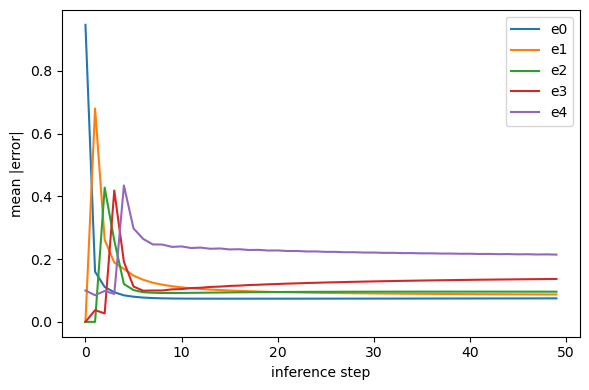

In [6]:
model.eval()
x, y = next(iter(train_loader))
x = x.to(device).view(x.size(0), -1)
yh = one_hot(y.to(device))
zs0 = model.init_latents(x.size(0))

_, logs = model.inference(x, y=yh, T=50, eta_z=ETA_Z, zs=zs0, log_errors=True)

plt.figure(figsize=(6,4))
for l in range(len(dims)):
    plt.plot(logs[f'e{l}'], label=f'e{l}')
plt.xlabel('inference step'); plt.ylabel('mean |error|'); plt.legend(); plt.tight_layout(); plt.show()


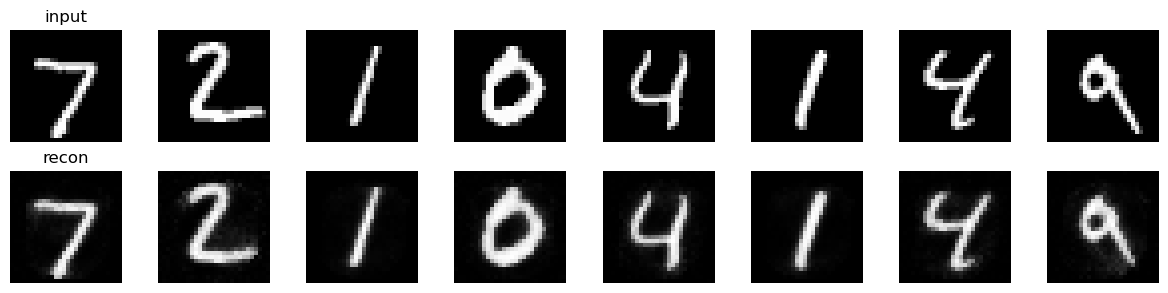

In [7]:
model.eval()
x, y = next(iter(test_loader))
x = x.to(device).view(x.size(0), -1)
zs, _ = model.inference(x, y=None, T=T_infer, eta_z=ETA_Z, zs=None, log_errors=False)
xhat = model.reconstruct(zs).clamp(-1,1)

k = 8
fig, axs = plt.subplots(2, k, figsize=(12,3))
for i in range(k):
    axs[0,i].imshow((x[i].view(28,28).cpu()+1)/2, cmap='gray'); axs[0,i].axis('off')
    axs[1,i].imshow((xhat[i].view(28,28).cpu()+1)/2, cmap='gray'); axs[1,i].axis('off')
axs[0,0].set_title('input'); axs[1,0].set_title('recon')
plt.tight_layout(); plt.show()


In [8]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device).view(x.size(0), -1)
        zs, _ = model.inference(x, y=None, T=T_infer, eta_z=ETA_Z, zs=None, log_errors=False)
        logits = model.classify(zs)
        pred = logits.argmax(dim=1).cpu()
        correct += (pred == y).sum().item()
        total += y.size(0)
test_acc = correct / total
print(f'Test accuracy (linear probe): {test_acc:.3f}')


Test accuracy (linear probe): 0.855
